# Exploratory Analysis of Cost and Utilization Data, 2001 - 2016

### Overview of the Three Different Levels of Summarization

#### Event Level
The individual event level provides payers, costs, and utilization data at the most granular level. There's Event Level data for dental (DUE), facility (FAE), medical provider (MPE), inpatient hospital (IPE), outpatient hospital (OPE), instituitional events (IUE), and prescription medicine events (PME).

#### Person Summary Level  (PS)
Summarizes all payers and costs across service categories and summarizes type of service amounts. "These records show only one total for each person, service, and payer"

#### Service Summary Level (SS)  
Summarizes at the service level: dental, facility, home health, hospice, medical provider, inpatient hospital, institutional, OP hospital, and prescribed medicines. If we add up all the SS categories by person, we get the PS values.


*Note that PS and SS variables are summarized in two ways. (1) summarized from event records, (2) adjusted to compensate for Medicare covered days that were not covered by interview reference periods.*

### Data Wrangling
Append Master Files (2001-2016) to combine data across years:

In [29]:
qui cd "J:\Geriatrics\Geri\MCBSProject"

qui use "Data\Master Files\MCBS_MASTER_2001.dta", clear

forvalues yr = 2002/2016 {
    if `yr'!=2014 {
        qui append using "Data\Master Files\MCBS_MASTER_`yr'.dta", force
    }
}


View number of Medicare beneficiaries by year:

In [30]:
tab year,missing


       year |      Freq.     Percent        Cum.
------------+-----------------------------------
       2001 |     17,931        7.22        7.22
       2002 |     17,739        7.14       14.36
       2003 |     17,428        7.02       21.37
       2004 |     16,994        6.84       28.22
       2005 |     17,095        6.88       35.10
       2006 |     17,561        7.07       42.17
       2007 |     18,066        7.27       49.44
       2008 |     15,777        6.35       55.79
       2009 |     15,946        6.42       62.21
       2010 |     16,079        6.47       68.68
       2011 |     16,331        6.57       75.25
       2012 |     16,454        6.62       81.88
       2013 |     16,174        6.51       88.39
       2015 |     14,068        5.66       94.05
       2016 |     14,778        5.95      100.00
------------+-----------------------------------
      Total |    248,421      100.00


We want to visualize total spending over time, so we need to keep the PS cost variables and year variable:

In [31]:
keep      pamt* year
describe  pamt*




              storage   display    value
variable name   type    format     label      variable label
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
pamtdu          double  %12.0g                Adj. sum for dental events
pamthh          double  %12.0g                Adj. sum for home health agency events
pamthp          double  %12.0g                Adj. sum for hospice events
pamtip          double  %12.0g                Adj. sum for inpatient events
pamtiu          double  %12.0g                Adj. sum for institutional events
pamtmp          double  %12.0g                Adj. sum for medical provider events
pamtop          double  %12.0g                Adj. sum for outpatient events
pamtpm          double  %12.0g                Adj. sum for prescribed medicine events
pamtf

Assert select spending variables are nonnegative:

In [32]:
foreach x in pamtcaid pamtcare pamtoop pamttot pamthp {
assert `x' >= 0 //Code breaks if this statement is false
}

gen n = 1 // After dataset is collapsed, this variable will contain the number of beneficiaries by year

Aggregate expense variables by year to get total spending:

In [33]:
qui ds year, not
qui collapse (sum) `r(varlist)', by(year)

*Label variables of interest
label var pamtcaid "Medicaid"
label var pamtcare "Medicare"
label var pamtoop  "Out-of-pocket"
label var pamttot  "Total payments"
label var pamthp   "Hospice payments"

label var n        "Number of Beneficiaries"


Browse aggregated amounts:

In [34]:
format n pamtcaid pamtcare pamtoop pamttot pamthp %15.4gc

list year n pamtcaid pamtcare pamtoop pamttot pamthp, sep(0)




     +---------------------------------------------------------------------------------+
     | year        n     pamtcaid      pamtcare      pamtoop       pamttot      pamthp |
     |---------------------------------------------------------------------------------|
  1. | 2001   17,931   25,801,960    66,171,367   32,427,594   157,766,394   1,497,622 |
  2. | 2002   17,739   24,781,234    72,666,327   32,767,338   165,394,872   1,798,149 |
  3. | 2003   17,428   23,612,136    75,434,946   33,297,819   165,710,692   2,106,381 |
  4. | 2004   16,994   24,950,294    78,871,971   33,059,816   170,672,387   2,495,619 |
  5. | 2005   17,095   27,682,469    82,125,887   33,390,804   180,413,442   2,704,711 |
  6. | 2006   17,561   23,008,380    93,930,045   34,638,652   189,203,697   3,233,805 |
  7. | 2007   18,066   22,978,786   101,004,171   35,520,596   196,530,690   3,131,986 |
  8. | 2008   15,777   22,797,479   100,132,788   33,046,755   194,992,726   3,716,489 |
  9. | 2009   15,9

Convert $ amount to millions:

In [35]:
qui ds year, not

foreach x in `r(varlist)' {

qui clonevar `x'_M = `x' //Converting $ amount to millions
qui clonevar `x'_n = `x' //Diving total spending by number of beneficiaries

qui replace `x'_M = `x'/1000000
qui replace `x'_n = `x'/n
}

## Time-series Line Plot of Select Expense Variables

Declare data to be time-series data:

In [36]:
tsset year 

        time variable:  year, 2001 to 2016, but with a gap
                delta:  1 unit


### Total Spending by Year

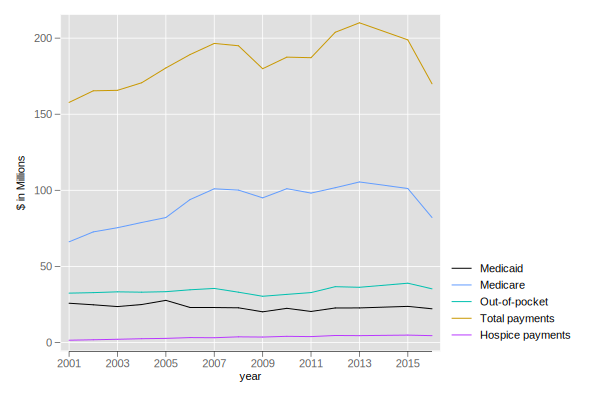

In [37]:
local vars pamtcaid_M pamtcare_M pamtoop_M pamttot_M pamthp_M

twoway (tsline `vars'), scheme(plottig) tscale(lwidth(vthin) lpattern(solid) line) xla(2001(2)2016) ///
                        ytitle("$ in Millions") yla(0(50)200)

### Total Spending Per Person by Year

In [38]:
list year n pamtcaid pamtcaid_n, sep(0)



     +---------------------------------------+
     | year        n     pamtcaid   pamt~d_n |
     |---------------------------------------|
  1. | 2001   17,931   25,801,960      1,439 |
  2. | 2002   17,739   24,781,234      1,397 |
  3. | 2003   17,428   23,612,136      1,355 |
  4. | 2004   16,994   24,950,294      1,468 |
  5. | 2005   17,095   27,682,469      1,619 |
  6. | 2006   17,561   23,008,380      1,310 |
  7. | 2007   18,066   22,978,786      1,272 |
  8. | 2008   15,777   22,797,479      1,445 |
  9. | 2009   15,946   20,162,193      1,264 |
 10. | 2010   16,079   22,447,139      1,396 |
 11. | 2011   16,331   20,394,439      1,249 |
 12. | 2012   16,454   22,684,232      1,379 |
 13. | 2013   16,174   22,725,062      1,405 |
 14. | 2015   14,068   23,737,188      1,687 |
 15. | 2016   14,778   22,142,732      1,498 |
     +---------------------------------------+


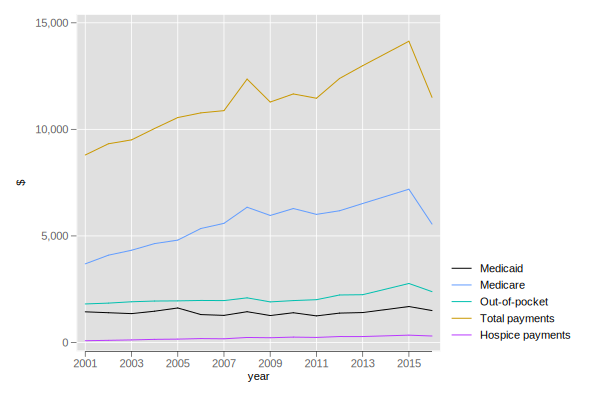

In [39]:
local vars pamtcaid_n pamtcare_n pamtoop_n pamttot_n pamthp_n

twoway (tsline `vars'), scheme(plottig) tscale(lwidth(vthin) lpattern(solid) line) xla(2001(2)2016) ///
                        ytitle("$") 

In [40]:
qui exit